# Capstone Project - The Battle of Neighbors: Week 2

## Introduction

Hi there! the objective of this notebook is to use Python's map modules along with Foursquare API to see where is the best point to open an italian restaurant. We want open a high level restaurant, which means that it must be placed in a noble area. I picked the Rio de Janeiro City, where I lived, as a target.

The strategy I chose was to get a visual sample of Rio's districts (not actualy a district, but more like a neighborhood. But I will call them districts through the notebook) and pick the noblest ones, preferably near the beach. Then, I checked how many italian restaurants are in each district. The final shot was to use a choropleth map (heatmap) to have a better visualization and then pick the place where the restaurant should be placed.

For the visual part, I used Geopandas, a module that works with geospatial data in python. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. To get the restaurants, I used Foursquare search API to see how many restaurants are.

## Coding

Let's start importing everything that is necessary:

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML
from pandas.io.json import json_normalize
import folium
import matplotlib.pyplot as plt

In [2]:
import geocoder
import requests
from bs4 import BeautifulSoup

In [3]:
import geopandas as gpd

## Data Acquisition - Districts

Let's start loading Rio de Janeiro's districts using Geopandas. The API is in Data-Rio website, and can be downloaded from the https://www.data.rio/datasets/limite-bairro url.

In [4]:
rio_api = r'https://pgeo3.rio.rj.gov.br/arcgis/rest/services/Basicos/mapa_basico_UTM/MapServer/15/query?where=1%3D1&outFields=*&outSR=4326&f=json'

It is a JSON type, so let's get it:

In [5]:
rio_json = requests.get(rio_api)

It is a huge set of data, so it is better to avoid printing it. But we can use **print(rio_json.json())** if we want to do so.  
Let's import this as a DataFrame using Geopandas

In [6]:
rio_df = gpd.read_file(rio_api)

So far, so good. As we can see, Geopandas can read the API as a dataframe, just as pandas does. Let's see if everything is alright:

In [7]:
rio_df.head()

,OBJECTID,Área,NOME,REGIAO_ADM,AREA_PLANE,CODBAIRRO,CODRA,CODBNUM,LINK,SHAPE.STArea(),SHAPE.STLength(),RP,Cod_RP,CODBAIRRO_LONG,geometry
0,325,1.705685e+06,Paquetá,PAQUETA,1,013,21,13,Paqueta&area=013 ...,1.705685e+06,24841.426669,Centro,1.1,13,"MULTIPOLYGON (((-43.10567 -22.74888, -43.10568..."
1,326,4.056403e+06,Freguesia (Ilha),ILHA DO GOVERNADOR,3,098,20,98,Freguesia (Ilha) &area=98 ...,4.056403e+06,18303.595717,Ilha do Governador,3.7,98,"MULTIPOLYGON (((-43.17170 -22.77661, -43.17170..."
2,327,9.780465e+05,Bancários,ILHA DO GOVERNADOR,3,097,20,97,Bancários &area=97 ...,9.780465e+05,7758.781282,Ilha do Governador,3.7,97,"MULTIPOLYGON (((-43.18915 -22.78318, -43.18913..."
3,328,1.895742e+07,Galeão,ILHA DO GOVERNADOR,3,104,20,104,Galeão &area=104 ...,1.895742e+07,21510.059220,Ilha do Governador,3.7,104,"MULTIPOLYGON (((-43.22804 -22.78374, -43.22798..."
4,329,1.672546e+06,Tauá,ILHA DO GOVERNADOR,3,101,20,101,Tauá &area=101 ...,1.672546e+06,8246.109606,Ilha do Governador,3.7,101,"POLYGON ((-43.18039 -22.79940, -43.18055 -22.7..."


In [8]:
rio_df.shape

(163, 15)

As we can see, Rio de Janeiro city has 163 districts, split in bigger regions (**REGIAO_ADM**). We can group them by these areas to see what we find:

In [9]:
rio_groups = rio_df.groupby('REGIAO_ADM').groups
rio_groups

{'ANCHIETA                ': Int64Index([20, 29, 30, 33], dtype='int64'),
 'BANGU': Int64Index([161], dtype='int64'),
 'BANGU                   ': Int64Index([51, 62, 159, 160, 162], dtype='int64'),
 'BARRA DA TIJUCA         ': Int64Index([124, 134, 138, 142, 144, 150, 152, 154], dtype='int64'),
 'BOTAFOGO                ': Int64Index([111, 120, 121, 122, 126, 128, 129, 135], dtype='int64'),
 'CAMPO GRANDE            ': Int64Index([57, 78, 79, 87, 158], dtype='int64'),
 'CENTRO': Int64Index([157], dtype='int64'),
 'CENTRO                  ': Int64Index([95], dtype='int64'),
 'CIDADE DE DEUS          ': Int64Index([130], dtype='int64'),
 'COMPLEXO DA MARE        ': Int64Index([38], dtype='int64'),
 'COMPLEXO DO ALEMÃO      ': Int64Index([49], dtype='int64'),
 'COPACABANA              ': Int64Index([139, 140], dtype='int64'),
 'GUARATIBA               ': Int64Index([123, 149, 153], dtype='int64'),
 'ILHA DO GOVERNADOR      ': Int64Index([1, 2, 3, 4, 5, 6, 8, 10, 13, 16, 18, 22, 26, 27, 4

We are not interested in most of the information concerning codes, so we are going to clean our DF:

In [10]:
rio_clean = rio_df[['NOME','REGIAO_ADM','CODBAIRRO','geometry']]
rio_clean.head()

,NOME,REGIAO_ADM,CODBAIRRO,geometry
0,Paquetá,PAQUETA,013,"MULTIPOLYGON (((-43.10567 -22.74888, -43.10568..."
1,Freguesia (Ilha),ILHA DO GOVERNADOR,098,"MULTIPOLYGON (((-43.17170 -22.77661, -43.17170..."
2,Bancários,ILHA DO GOVERNADOR,097,"MULTIPOLYGON (((-43.18915 -22.78318, -43.18913..."
3,Galeão,ILHA DO GOVERNADOR,104,"MULTIPOLYGON (((-43.22804 -22.78374, -43.22798..."
4,Tauá,ILHA DO GOVERNADOR,101,"POLYGON ((-43.18039 -22.79940, -43.18055 -22.7..."


Where **NOME** = name and **CODBAIRRO** is a code for the district

We are aiming to open an italian restaurant and we want to see where at in the noblest areas. So we are interested in **REGIAO_ADM** corresponding to BARRA DA TIJUCA, BOTAFOGO, CENTRO and LAGOA. Let's check what districts are in LAGOA region:

rio_clean.groupby('REGIAO_ADM').get_group('LAGOA')

There was an error. That's because LAGOA is really 'LAGOA &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;', so let's get rid of theses spaces:

In [11]:
rio_clean.NOME = rio_clean.NOME.str.strip()
rio_clean.REGIAO_ADM = rio_clean.REGIAO_ADM.str.strip()

C:\Users\Andre\anaconda3\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Let's check again:

In [12]:
rio_clean.groupby('REGIAO_ADM').get_group('LAGOA').NOME

137    Jardim Botânico
141              Lagoa
143              Gávea
145             Leblon
146            Ipanema
147        São Conrado
151            Vidigal
Name: NOME, dtype: object

We can see that the Lagoa region has 7 disctricts.  

The population is an important data to see if a place is suitable to have a restaurant. Let's get some data about Rio's population:

In [13]:
col_pop = ['NOME', 'Population', 'Residencies']
rio_pop = pd.read_excel(r'C:\Users\Andre\Documents\Cursos\IBM\Final capstone\pop_por_bairro.xlsx', skiprows = 6, names = col_pop)

In [14]:
rio_pop.head()

,NOME,Population,Residencies
0,Acari,27347.0,8125.0
1,Água Santa,8756.0,3660.0
2,Alto da Boa Vista,9343.0,3125.0
3,Anchieta,55652.0,17712.0
4,Andaraí,39365.0,14710.0


Let's merge with rio_clean:

In [15]:
rio_clean_pop = pd.merge(rio_clean, rio_pop, on = 'NOME')
rio_clean_pop.head()

,NOME,REGIAO_ADM,CODBAIRRO,geometry,Population,Residencies
0,Paquetá,PAQUETA,013,"MULTIPOLYGON (((-43.10567 -22.74888, -43.10568...",3361.0,1256.0
1,Bancários,ILHA DO GOVERNADOR,097,"MULTIPOLYGON (((-43.18915 -22.78318, -43.18913...",12512.0,4088.0
2,Galeão,ILHA DO GOVERNADOR,104,"MULTIPOLYGON (((-43.22804 -22.78374, -43.22798...",22971.0,7398.0
3,Tauá,ILHA DO GOVERNADOR,101,"POLYGON ((-43.18039 -22.79940, -43.18055 -22.7...",29567.0,9851.0
4,Portuguesa,ILHA DO GOVERNADOR,103,"MULTIPOLYGON (((-43.20763 -22.79498, -43.20757...",23856.0,8306.0


We will concatenate the other regions in a new DF:

In [16]:
r_grouped = rio_clean_pop.groupby('REGIAO_ADM')
zsc = pd.concat([group for (name, group) in r_grouped if name in ['LAGOA', 'COPACABANA', 'CENTRO', 'BOTAFOGO','BARRA DA TIJUCA']])

Let's check:

In [17]:
print(zsc)

                         NOME       REGIAO_ADM CODBAIRRO  \
118             Vargem Grande  BARRA DA TIJUCA       131   
128                   Camorim  BARRA DA TIJUCA       129   
132            Vargem Pequena  BARRA DA TIJUCA       130   
136                 Itanhangá  BARRA DA TIJUCA       127   
138           Barra da Tijuca  BARRA DA TIJUCA       128   
144  Recreio dos Bandeirantes  BARRA DA TIJUCA       132   
146                       Joá  BARRA DA TIJUCA       126   
148                   Grumari  BARRA DA TIJUCA       133   
105                    Glória         BOTAFOGO       016   
114                    Catete         BOTAFOGO       018   
115                  Flamengo         BOTAFOGO       015   
116               Laranjeiras         BOTAFOGO       017   
120               Cosme Velho         BOTAFOGO       019   
122                  Botafogo         BOTAFOGO       020   
123                      Urca         BOTAFOGO       022   
129                   Humaitá         BO

Let's see in a map, but first we will obtain the coordinates for displying the districts' names:

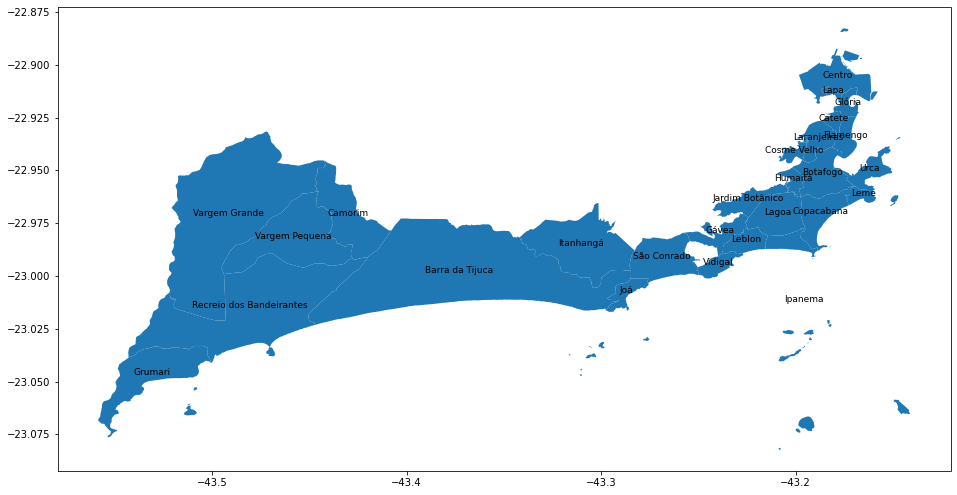

In [18]:
zsc['coords'] = zsc['geometry'].apply(lambda x: x.representative_point().coords[:])
zsc['coords'] = [coords[0] for coords in zsc['coords']]
ax = zsc.plot(figsize = (16,10))
zsc.apply(lambda x: ax.annotate(s=x.NOME, 
                                xy=x.geometry.centroid.coords[0], 
                                ha='center', 
                                size = 9, 
                                color = 'black', 
                                ),axis=1);

Compared with the other districts:

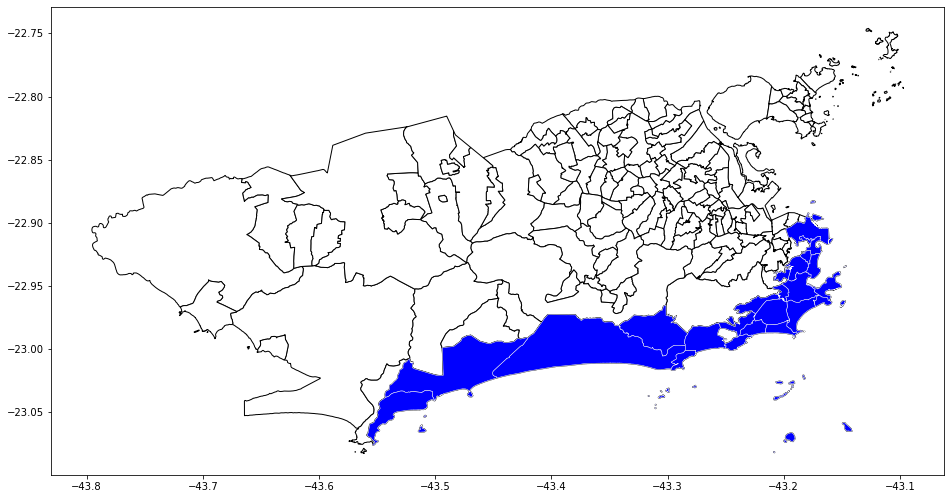

In [60]:
base = rio_clean.plot(color='white', edgecolor='black', figsize = (16,10))
zsc.plot(ax=base, edgecolor='white', color='blue', linewidth=0.5);

Let's check again zsc:

In [20]:
zsc.head()

,NOME,REGIAO_ADM,CODBAIRRO,geometry,Population,Residencies,coords
118,Vargem Grande,BARRA DA TIJUCA,131,"POLYGON ((-43.44281 -22.94526, -43.44219 -22.9...",14039.0,4492.0,"(-43.49577342658546, -22.976312858989203)"
128,Camorim,BARRA DA TIJUCA,129,"POLYGON ((-43.43624 -22.94866, -43.43623 -22.9...",1970.0,659.0,"(-43.43290640793579, -22.968721809565075)"
132,Vargem Pequena,BARRA DA TIJUCA,130,"POLYGON ((-43.43854 -22.98201, -43.43819 -22.9...",20973.0,6338.0,"(-43.457557071471705, -22.97939754918046)"
136,Itanhangá,BARRA DA TIJUCA,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...",41801.0,13997.0,"(-43.31202118738386, -22.9854727536549)"
138,Barra da Tijuca,BARRA DA TIJUCA,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...",136831.0,51427.0,"(-43.37343120677338, -22.997902330024047)"


Let's split the centroids in two columns: longitude and latitude. The centroids are the coordinate points that are equals to the edges.

In [21]:
zsc['longitude'] = zsc.centroid.x
zsc['latitude'] = zsc.centroid.y

<ipython-input-21-7fcac361c12e>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zsc['longitude'] = zsc.centroid.x
<ipython-input-21-7fcac361c12e>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zsc['latitude'] = zsc.centroid.y


In [22]:
zsc.head()

,NOME,REGIAO_ADM,CODBAIRRO,geometry,Population,Residencies,coords,longitude,latitude
118,Vargem Grande,BARRA DA TIJUCA,131,"POLYGON ((-43.44281 -22.94526, -43.44219 -22.9...",14039.0,4492.0,"(-43.49577342658546, -22.976312858989203)",-43.491810,-22.971778
128,Camorim,BARRA DA TIJUCA,129,"POLYGON ((-43.43624 -22.94866, -43.43623 -22.9...",1970.0,659.0,"(-43.43290640793579, -22.968721809565075)",-43.430378,-22.971515
132,Vargem Pequena,BARRA DA TIJUCA,130,"POLYGON ((-43.43854 -22.98201, -43.43819 -22.9...",20973.0,6338.0,"(-43.457557071471705, -22.97939754918046)",-43.458550,-22.982479
136,Itanhangá,BARRA DA TIJUCA,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...",41801.0,13997.0,"(-43.31202118738386, -22.9854727536549)",-43.310079,-22.985885
138,Barra da Tijuca,BARRA DA TIJUCA,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...",136831.0,51427.0,"(-43.37343120677338, -22.997902330024047)",-43.372885,-22.998700


We are not going to work with some districts, so we'll get rid of them:

In [23]:
zsc = zsc[3:]

In [24]:
zsc.head()

,NOME,REGIAO_ADM,CODBAIRRO,geometry,Population,Residencies,coords,longitude,latitude
136,Itanhangá,BARRA DA TIJUCA,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...",41801.0,13997.0,"(-43.31202118738386, -22.9854727536549)",-43.310079,-22.985885
138,Barra da Tijuca,BARRA DA TIJUCA,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...",136831.0,51427.0,"(-43.37343120677338, -22.997902330024047)",-43.372885,-22.998700
144,Recreio dos Bandeirantes,BARRA DA TIJUCA,132,"POLYGON ((-43.43787 -22.99512, -43.43744 -22.9...",84224.0,29118.0,"(-43.47024396165992, -23.01510158223853)",-43.480828,-23.015096
146,Joá,BARRA DA TIJUCA,126,"POLYGON ((-43.27559 -23.00329, -43.27559 -23.0...",818.0,251.0,"(-43.29025340031879, -23.00905426219122)",-43.287221,-23.007962
148,Grumari,BARRA DA TIJUCA,133,"MULTIPOLYGON (((-43.50815 -23.03310, -43.50715...",167.0,44.0,"(-43.54288482797882, -23.054642062865497)",-43.530915,-23.046759


## Foursquare Data Acquisition and methodology

Now we are ready to see how many italian restaurants are in these neighbours. We will check with Foursquare. To do this, you'll have to create an account. There you will get an ID and a Password that will be used to access the search API.

In [25]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 3BMB5H2JEK3J34M3KWYNYBJXMC3CZO5U4LIS0TUIZVZIHIX4
CLIENT_SECRET:BWOJIKVLFAP2H3TZMBMYT5QBFMXPG1POTP3XSX5TADOKTGJQ


Let's try to find an italian restaurant in downtown district (centro):

In [26]:
i_rest = 'italian restaurant'
radius = 1000
latitude = -22.906296
longitude = -43.178565

In [27]:
page = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.\
format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, i_rest, radius, LIMIT)

In [28]:
results = requests.get(page).json()
results

{'meta': {'code': 200, 'requestId': '5fceae32e7493902039e0c73'},
 'response': {'venues': [{'id': '501173cfe4b01be621292bc3',
    'name': 'Restaurante Biasibet',
    'location': {'lat': -22.905828811102328,
     'lng': -43.17814287947954,
     'labeledLatLngs': [{'label': 'display',
       'lat': -22.905828811102328,
       'lng': -43.17814287947954}],
     'distance': 67,
     'cc': 'BR',
     'country': 'Brasil',
     'formattedAddress': ['Brasil']},
    'categories': [{'id': '4bf58dd8d48988d1df931735',
      'name': 'BBQ Joint',
      'pluralName': 'BBQ Joints',
      'shortName': 'BBQ',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bbqalt_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1607380530',
    'hasPerk': False},
   {'id': '4fb28704e4b0a0d79a92ec3d',
    'name': 'Joquei Club Restaurante',
    'location': {'lat': -22.906889064001273,
     'lng': -43.178752987185604,
     'labeledLatLngs': [{'label': 'display',
       'lat': -

We have to apply this search for the other 23 districts. So let's create a function that extracts the data and transforms into a DataFrame

In [29]:
def ext_api(latitude, longitude):
    CLIENT_ID =  # your Foursquare ID
    CLIENT_SECRET =  # your Foursquare Secret
    VERSION = '20180604'
    LIMIT = 30
    i_rest = 'Italian restaurant'
    radius = 1000
    page = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.\
    format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, i_rest, radius, LIMIT)
    results = requests.get(page).json()
    venues = results['response']['venues']
    ita_df = json_normalize(venues)
    return ita_df

In [30]:
ita_app = ext_api(-22.985885,-43.310079) #testing the function

<ipython-input-29-bc622c459d9e>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  ita_df = json_normalize(venues)


In [31]:
ita_app = ext_api(-22.985885,-43.310079)
#creating an empty list to see how many restaurants are in each district
counter = []
#Using a for loop to weep the radius through the centroids
for (lat, long) in zsc[['latitude', 'longitude']].itertuples(index = False):
    ita_rest = ext_api(lat,long)
    index = len(ita_rest.index)
    counter.append(index)
    #concatenate the dataframes
    ita_app = ita_app.append([ita_rest])
    
ita_app.shape

<ipython-input-29-bc622c459d9e>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  ita_df = json_normalize(venues)


(417, 19)

In [32]:
len(counter) # number of districts

24

In [33]:
sum(counter) #number of restaurants

409

Counter is a list where each key is the number of restaurants per disctrict. If we want to know how many italian restaurants are in Botafogo, we can type:

In [34]:
counter[10]

30

In [35]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
#filtering the dataframe
filtered_columns = ['name', 'categories'] + [col for col in ita_app.columns if col.startswith('location.')] + ['id']
dataframe_filtered = ita_app.loc[:, filtered_columns]
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

In [36]:
dataframe_filtered.head()

,name,categories,lat,lng,labeledLatLngs,distance,cc,country,formattedAddress,address,postalCode,city,state,crossStreet,neighborhood,id
0,Restaurante e Pizzaria Rio,BBQ Joint,-22.987046,-43.308058,"[{'label': 'display', 'lat': -22.987046, 'lng'...",244,BR,Brasil,[Brasil],NaN,NaN,NaN,NaN,NaN,NaN,50da5d92e4b0f031306daffb
1,Restaurante Trapiá,Brazilian Restaurant,-22.987756,-43.309647,"[{'label': 'display', 'lat': -22.9877560659973...",212,BR,Brasil,[Brasil],NaN,NaN,NaN,NaN,NaN,NaN,5000a8cfe4b0eb34b481f287
2,Bar & Restaurante do Sérgio,Brazilian Restaurant,-22.987730,-43.308740,"[{'label': 'display', 'lat': -22.9877297185207...",246,BR,Brasil,"[Estr. do Itanhangá, Rio de Janeiro, RJ, 22753...",Estr. do Itanhangá,22753-005,Rio de Janeiro,RJ,NaN,NaN,5308d9a811d2fafb94c13d85
3,restaurante 3115,Brazilian Restaurant,-22.987176,-43.307726,"[{'label': 'display', 'lat': -22.9871757918850...",280,BR,Brasil,"[Tijuquinha, Rio de Janeiro, RJ, Brasil]",Tijuquinha,NaN,Rio de Janeiro,RJ,NaN,NaN,4d961cf9d7366a314741f50a
4,Valcy Mar Bar e Restaurante,Beer Garden,-22.987158,-43.306882,"[{'label': 'display', 'lat': -22.9871578686025...",356,BR,Brasil,"[Itanhangá (Rua Pau Brasil), Rio de Janeiro, R...",Itanhangá,22641-005,Rio de Janeiro,RJ,Rua Pau Brasil,NaN,554babf0498ef01c99ea4d1a


In [37]:
dataframe_filtered.shape

(417, 16)

## Results

Now let's see how many italian restaurants are in each district (Number of restaurantes - Número de restaurantes):

In [38]:
zsc.insert(2, "Numero_de_restaurantes", counter, True) # inserting a column called Numero_de_restaurantes using the counter list

In [39]:
zsc.head(24)

,NOME,REGIAO_ADM,Numero_de_restaurantes,CODBAIRRO,geometry,Population,Residencies,coords,longitude,latitude
136,Itanhangá,BARRA DA TIJUCA,8,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...",41801.0,13997.0,"(-43.31202118738386, -22.9854727536549)",-43.310079,-22.985885
138,Barra da Tijuca,BARRA DA TIJUCA,9,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...",136831.0,51427.0,"(-43.37343120677338, -22.997902330024047)",-43.372885,-22.998700
144,Recreio dos Bandeirantes,BARRA DA TIJUCA,13,132,"POLYGON ((-43.43787 -22.99512, -43.43744 -22.9...",84224.0,29118.0,"(-43.47024396165992, -23.01510158223853)",-43.480828,-23.015096
146,Joá,BARRA DA TIJUCA,4,126,"POLYGON ((-43.27559 -23.00329, -43.27559 -23.0...",818.0,251.0,"(-43.29025340031879, -23.00905426219122)",-43.287221,-23.007962
148,Grumari,BARRA DA TIJUCA,1,133,"MULTIPOLYGON (((-43.50815 -23.03310, -43.50715...",167.0,44.0,"(-43.54288482797882, -23.054642062865497)",-43.530915,-23.046759
105,Glória,BOTAFOGO,30,016,"POLYGON ((-43.16828 -22.91094, -43.16825 -22.9...",9661.0,4564.0,"(-43.17492363193883, -22.918170280827155)",-43.173277,-22.919102
114,Catete,BOTAFOGO,30,018,"POLYGON ((-43.17643 -22.92562, -43.17645 -22.9...",24057.0,10446.0,"(-43.180833660893924, -22.92713012109943)",-43.180188,-22.926646
115,Flamengo,BOTAFOGO,30,015,"POLYGON ((-43.16887 -22.92465, -43.16887 -22.9...",50043.0,23230.0,"(-43.17492210117102, -22.93434828625649)",-43.174182,-22.934711
116,Laranjeiras,BOTAFOGO,29,017,"POLYGON ((-43.18144 -22.92950, -43.18081 -22.9...",45554.0,18867.0,"(-43.18652517035371, -22.936319414528384)",-43.188493,-22.935348
120,Cosme Velho,BOTAFOGO,6,019,"POLYGON ((-43.19638 -22.94503, -43.19956 -22.9...",7178.0,2377.0,"(-43.20046825501165, -22.94063589127018)",-43.200735,-22.941586


We can now apply a choropleth map to easily see italian restaurants distribuition

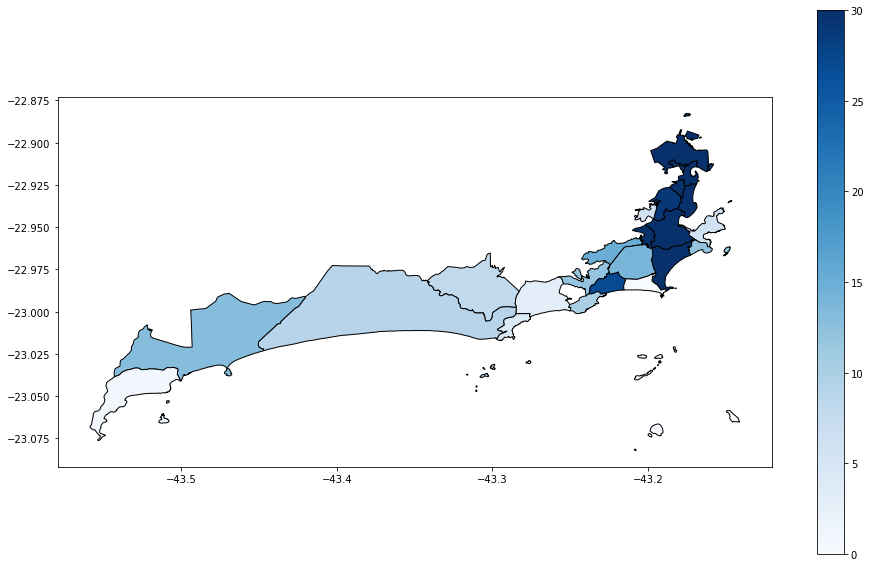

In [40]:
zsc.plot(column = 'Numero_de_restaurantes', 
         cmap = 'Blues', 
         figsize = (16,10), 
         legend = True, 
         edgecolor = 'black')

We can check the population as well:

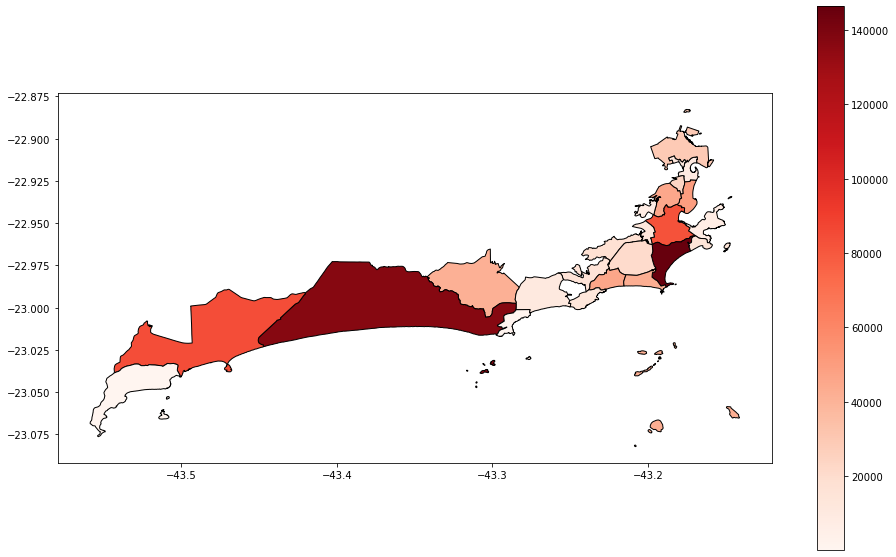

In [61]:
zsc.plot(column = 'Population', 
         cmap = 'Reds', 
         figsize = (16,10), 
         legend = True, 
         edgecolor = 'black')
plt.savefig('~data\population.png')
plt.show()

## Conclusion

As we can see, there are noble places where there is no italian restaurants, and other places with 8. As a former Rio dweller, I know that Itanhangá, Joá and São Conrado are not good places to open a restaurant, because of their geography. Recreio and Barra da Tijuca are good places, but far from the places with higher densities. The best point considering the map density could be **Ipanema**, which is a beach region known worldwide and, surprisingly, with no italian restaurants. The reason is that Ipanema's centroid is probably located in the middle of the sea, and the radius picked probably did not reach the land. One way to do this is run the ext_api function with coordinates obtained by Geocoder.

In [42]:
ipanema_ita = ext_api(-22.9862794,-43.2055871)

<ipython-input-29-bc622c459d9e>:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  ita_df = json_normalize(venues)


In [43]:
ipanema_ita.head()

,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.address,location.crossStreet,location.neighborhood
0,5da5e0f2a5ea47000745bf14,Restaurante Gajos D'ouro - Ipanema,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1607380541,False,-22.985662,-43.206142,"[{'label': 'display', 'lat': -22.985662, 'lng'...",89,22420-041,BR,Rio de Janeiro,RJ,Brasil,"[Rio de Janeiro, RJ, 22420-041, Brasil]",NaN,NaN,NaN
1,4fe2f82be4b0f9f7507ae04d,rooftop restaurant @ Everest Rio Hotel,"[{'id': '4bf58dd8d48988d16b941735', 'name': 'B...",v-1607380541,False,-22.985087,-43.203336,"[{'label': 'display', 'lat': -22.9850874014325...",266,NaN,BR,NaN,NaN,Brasil,[Brasil],NaN,NaN,NaN
2,50af90ece4b047828ac985fd,Ranguitos Restaurante,"[{'id': '4bf58dd8d48988d16b941735', 'name': 'B...",v-1607380541,False,-22.984680,-43.206129,"[{'label': 'display', 'lat': -22.9846801873595...",186,NaN,BR,Rio de Janeiro,RJ,Brasil,[Visconde de Pirajá 365 loja 19 (Maria Quitéri...,Visconde de Pirajá 365 loja 19,Maria Quitéria,NaN
3,550f36af498e2a7e905b31ff,Quitéria Restaurante,"[{'id': '4bf58dd8d48988d16b941735', 'name': 'B...",v-1607380541,False,-22.985519,-43.207222,"[{'label': 'display', 'lat': -22.985519, 'lng'...",187,22410-040,BR,Rio de Janeiro,RJ,Brasil,"[Ipanema Inn (Térreo), Rio de Janeiro, RJ, 224...",Ipanema Inn,Térreo,Ipanema
4,4fb52af1e4b059afc6a6ac01,Restaurante Da Anna Ipanema,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1607380541,False,-22.984705,-43.206167,"[{'label': 'display', 'lat': -22.9847047078140...",185,NaN,BR,NaN,NaN,Brasil,[Brasil],NaN,NaN,NaN


In [44]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
#filtering the dataframe
filtered_columns = ['name', 'categories'] + [col for col in ipanema_ita.columns if col.startswith('location.')] + ['id']
dataframe_filtered = ipanema_ita.loc[:, filtered_columns]
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

In [45]:
dataframe_filtered.shape

(30, 16)

As we can see, there are 30 restaurants located in Ipanema, but but few of them are italian, so we can still pick Ipanema as a place to open an italian restaurant. Let's update our dataframe, but first, we are going to rest the index:

In [46]:
zsc = zsc.reset_index(drop = True)

In [47]:
zsc['Numero_de_restaurantes'].iloc[21] = 30
zsc.head()

C:\Users\Andre\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,NOME,REGIAO_ADM,Numero_de_restaurantes,CODBAIRRO,geometry,Population,Residencies,coords,longitude,latitude
0,Itanhangá,BARRA DA TIJUCA,8,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...",41801.0,13997.0,"(-43.31202118738386, -22.9854727536549)",-43.310079,-22.985885
1,Barra da Tijuca,BARRA DA TIJUCA,9,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...",136831.0,51427.0,"(-43.37343120677338, -22.997902330024047)",-43.372885,-22.998700
2,Recreio dos Bandeirantes,BARRA DA TIJUCA,13,132,"POLYGON ((-43.43787 -22.99512, -43.43744 -22.9...",84224.0,29118.0,"(-43.47024396165992, -23.01510158223853)",-43.480828,-23.015096
3,Joá,BARRA DA TIJUCA,4,126,"POLYGON ((-43.27559 -23.00329, -43.27559 -23.0...",818.0,251.0,"(-43.29025340031879, -23.00905426219122)",-43.287221,-23.007962
4,Grumari,BARRA DA TIJUCA,1,133,"MULTIPOLYGON (((-43.50815 -23.03310, -43.50715...",167.0,44.0,"(-43.54288482797882, -23.054642062865497)",-43.530915,-23.046759


Of course we can refine our analysis further. For example, we may see either overlaping restaurants in smaller districts or areas with no restaurants in bigger districts. We can solve this putting more than 1 centroid for the bigger areas and using the districts' areas provided by the API, and estimate a radius for each area. But the main objective of this work was to use Foursquare with a visual tool that is as good as Folium. Other issue is the Foursquare query mechanism, that must be improved (Satyricon is a seafood restaurant that may be considered italian, and it is in Ipanema), and because a search for "Italian Restaurants" results in several categories. 

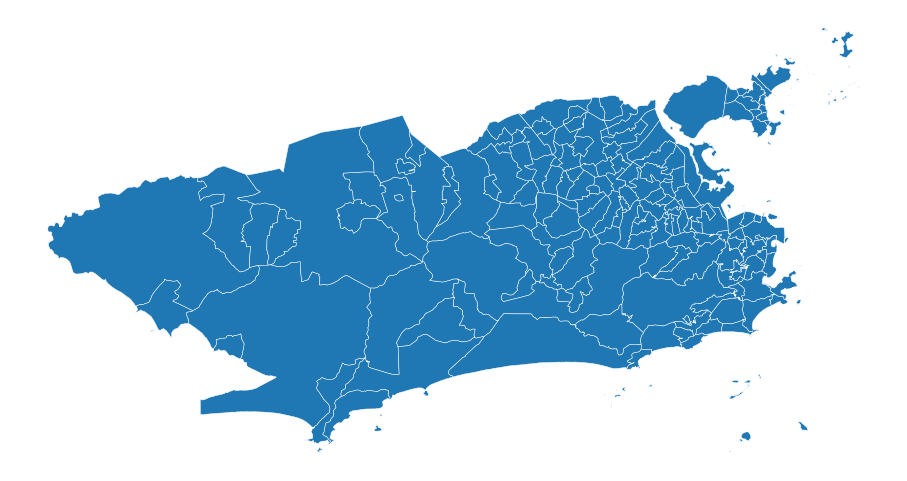

In [48]:
rio_clean.plot(figsize = (16,9), edgecolor='white', linewidth=0.5)
plt.axis('off')
plt.savefig('~data\rio_bairros.png', bbox_inches='tight')
plt.show()

Let's check again the number of restaurants:

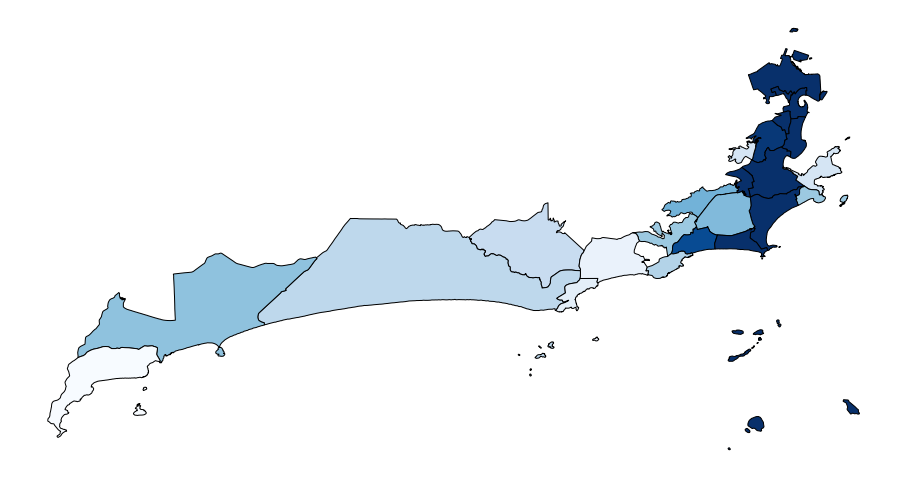

In [49]:
zsc.plot(column = 'Numero_de_restaurantes', 
         cmap = 'Blues', 
         figsize = (16,10), 
         edgecolor = 'black')
plt.axis('off')
plt.savefig('~data\zsc.png', bbox_inches='tight')
plt.show()

We can stipulate a column which calculates how many people are for restaurant:

In [50]:
zsc['people_per_restaurant'] = zsc['Population']/zsc['Numero_de_restaurantes']
zsc.head()

,NOME,REGIAO_ADM,Numero_de_restaurantes,CODBAIRRO,geometry,Population,Residencies,coords,longitude,latitude,people_per_restaurant
0,Itanhangá,BARRA DA TIJUCA,8,127,"POLYGON ((-43.28271 -22.98794, -43.28301 -22.9...",41801.0,13997.0,"(-43.31202118738386, -22.9854727536549)",-43.310079,-22.985885,5225.125000
1,Barra da Tijuca,BARRA DA TIJUCA,9,128,"MULTIPOLYGON (((-43.40291 -22.97270, -43.40232...",136831.0,51427.0,"(-43.37343120677338, -22.997902330024047)",-43.372885,-22.998700,15203.444444
2,Recreio dos Bandeirantes,BARRA DA TIJUCA,13,132,"POLYGON ((-43.43787 -22.99512, -43.43744 -22.9...",84224.0,29118.0,"(-43.47024396165992, -23.01510158223853)",-43.480828,-23.015096,6478.769231
3,Joá,BARRA DA TIJUCA,4,126,"POLYGON ((-43.27559 -23.00329, -43.27559 -23.0...",818.0,251.0,"(-43.29025340031879, -23.00905426219122)",-43.287221,-23.007962,204.500000
4,Grumari,BARRA DA TIJUCA,1,133,"MULTIPOLYGON (((-43.50815 -23.03310, -43.50715...",167.0,44.0,"(-43.54288482797882, -23.054642062865497)",-43.530915,-23.046759,167.000000


In [51]:
#Exporting the Dataframe
zsc.to_excel('~data\zsc.xlsx')

Let's see some graphics to have a better visualization:

Text(0, 0.5, 'População')

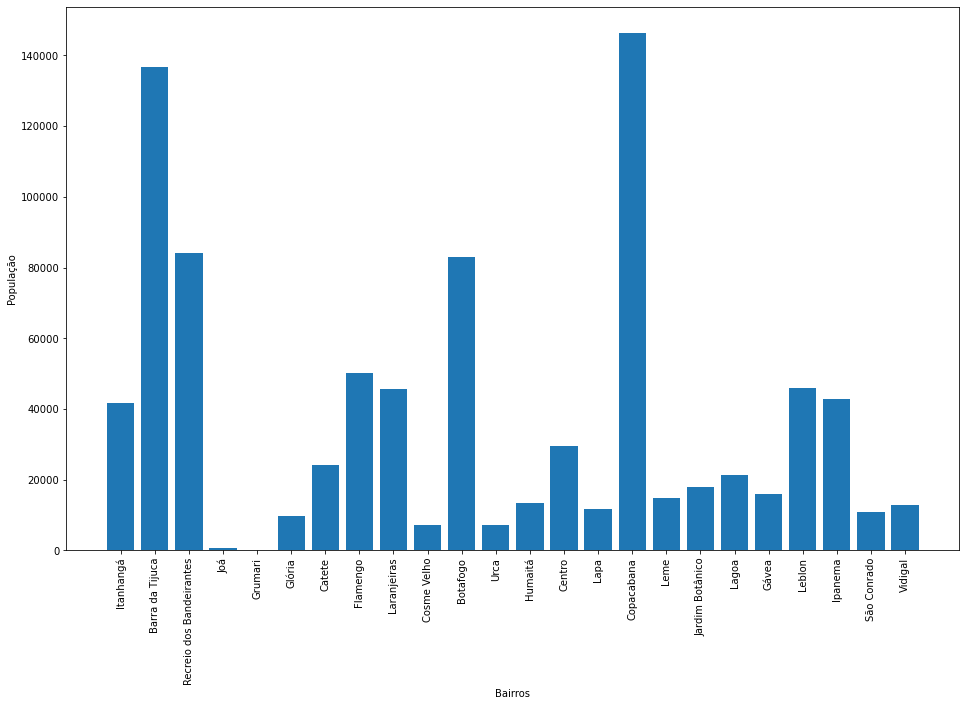

In [52]:
plt.figure(figsize = (16,10))
plt.bar(zsc['NOME'],zsc['Population'])
plt.xticks(rotation = 'vertical')
plt.xlabel('Bairros')
plt.ylabel('População')

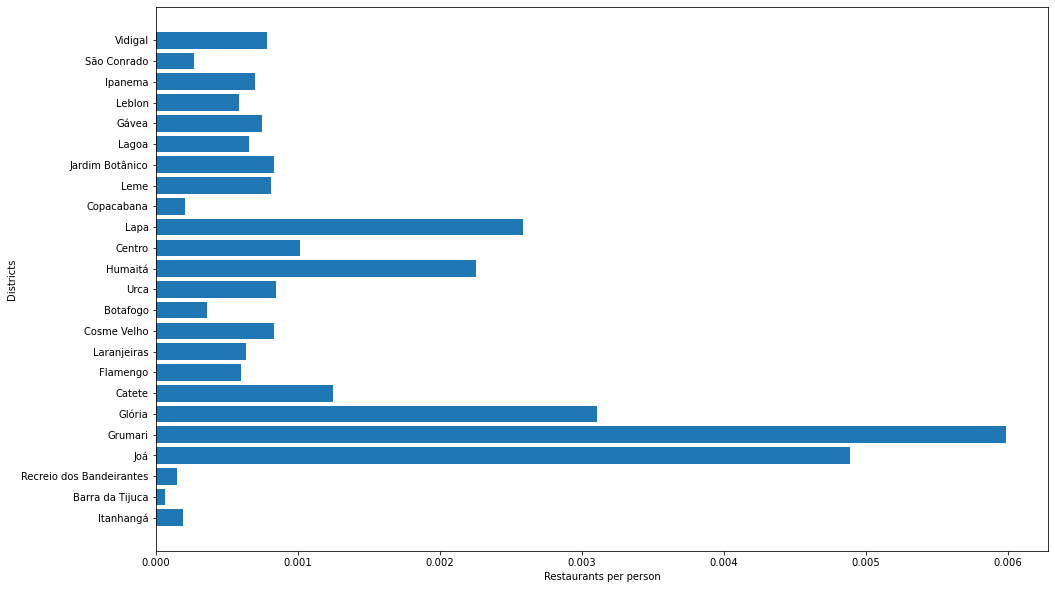

In [64]:
plt.figure(figsize = (16,10))
plt.barh(zsc['NOME'],1/zsc['people_per_restaurant'])
#plt.xticks(rotation = 'vertical')
#plt.yticks(np.arange(0, 0.001, step=0.0001))
plt.xlabel('Restaurants per person')
plt.ylabel('Districts')
plt.savefig('~data\barras-restpp.png')
plt.show()

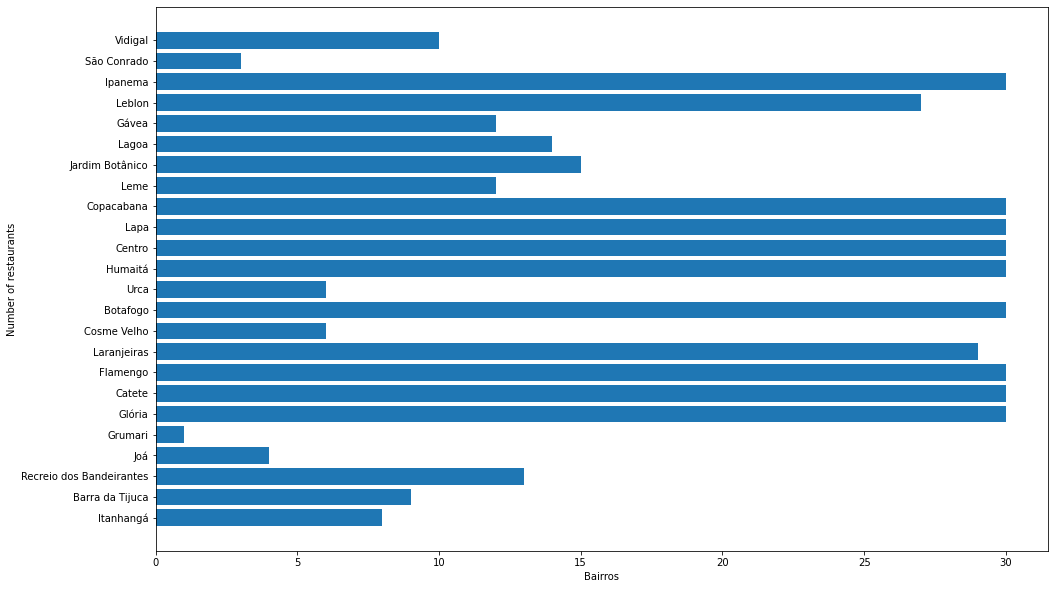

In [62]:
plt.figure(figsize = (16,10))
plt.barh(zsc['NOME'],zsc['Numero_de_restaurantes'])
#plt.xticks(rotation = 'vertical')
#plt.yticks(np.arange(0, 0.001, step=0.0001))
plt.xlabel('Bairros')
plt.ylabel('Number of restaurants')
plt.show()

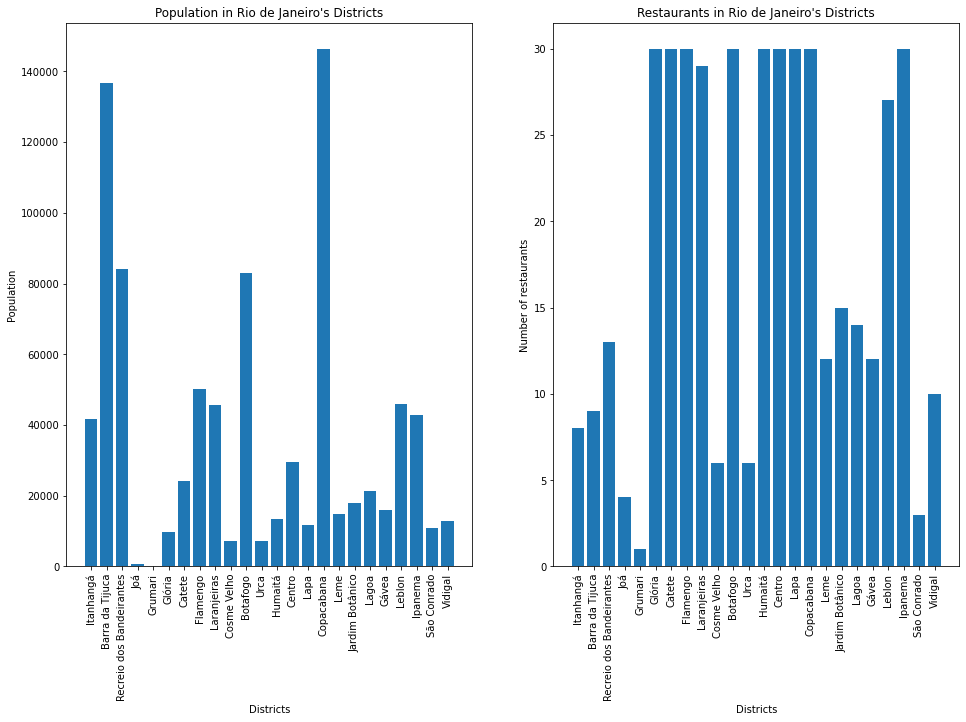

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].bar(zsc['NOME'],zsc['Population'])
ax[0].set_xticklabels(zsc['NOME'], rotation = 90)
ax[0].set_title("Population in Rio de Janeiro's Districts")
ax[0].set_xlabel('Districts')
ax[0].set_ylabel('Population')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=None)
ax[1].bar(zsc['NOME'],zsc['Numero_de_restaurantes'])
ax[1].set_xticklabels(zsc['NOME'], rotation = 90)
ax[1].set_title("Restaurants in Rio de Janeiro's Districts")
ax[1].set_xlabel('Districts')
ax[1].set_ylabel('Number of restaurants')
plt.savefig('~data\barras.png')
plt.show()

Let's put everything together in an interactive map using bokeh:

In [56]:
import json
from bokeh.io import show, output_notebook
from bokeh.models import (CDSView, ColorBar, ColumnDataSource, CustomJS,
                          CustomJSFilter, GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider, Label)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure


In [57]:
geosource = GeoJSONDataSource(geojson = zsc.to_json())

In [58]:
output_notebook()

Loading BokehJS ...

In [59]:
# Define color palettes
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 160000)

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper_v = LinearColorMapper(palette = palette, low = 0, high = 30)

# Define custom tick labels for horizontal color bar.
tick_labels = {'0': '0', '20000': '20,000',
               '40000':'40,000', '60000':'60,000',
               '80000':'80,000', '1000000':'100,000',
               '120000':'120,000', '140000':'140,000',
               '160000':'160,000+'}

# Define custom tick labels for vertical color bar.
tick_labels_v = {'0': '0', '3': '3', '6':'6', 
                 '10':'10', '15':'15',
                 '20':'20', '25':'25',
                 '30':'30+'}

# Create horizontal color bar.
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal',
                     major_label_overrides = tick_labels)

# Create vertical color bar.
color_bar_v = ColorBar(color_mapper=color_mapper_v, label_standoff=9,width = 20, height = 400,
                     border_line_color=None,location = (0,0), orientation = 'vertical',
                     major_label_overrides = tick_labels_v)

# Create figure object.
p = figure(title = 'Restaurantes Italianos em bairros da zona sul', 
           plot_height = 600 ,
           plot_width = 950, toolbar_location = 'below', 
           tools = "pan, wheel_zoom, box_zoom, reset, save")
p.title.align = "center"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,
                   fill_color = {'field' :'Population', 'transform' : color_mapper},
                   line_color = 'black', line_width = 1, fill_alpha = 1)

# Create hover tool
p.add_tools(HoverTool(renderers = [states], 
                      tooltips = [('Nome','@NOME'),('Numero de restaurantes', '@Numero_de_restaurantes'), 
                                  ('PPR', '@people_per_restaurant{(0.00)}')]))


# Specify layout
p.add_layout(color_bar, 'below')
p.add_layout(color_bar_v, 'right')
show(p)

Now we can see that when we use the population to complement restaurant data, we can see that there are more people per restaurant (ppr) in Barra da Tijuca, with over 15,000 ppr. So, the best place to open a restaurant would be **Barra da Tijuca**.